# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Ingest Data

In [5]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [6]:
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [9]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

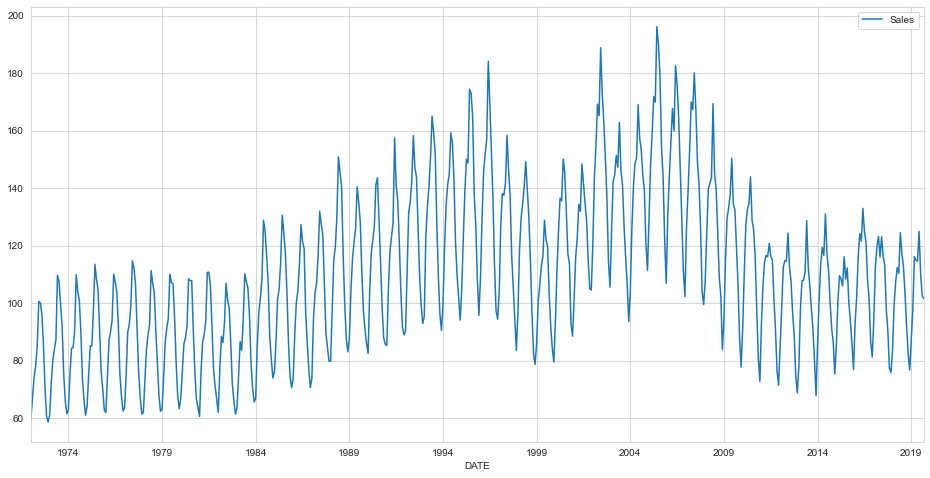

In [10]:
df.plot(figsize=(16,8))

In [11]:
len(df)

573

## Preprocessing of Data

### Train Test Split

In [12]:
test_size = 24

In [13]:
test_indx = len(df) - test_size
test_indx

549

In [16]:
train = df.iloc[:test_indx]
test = df.iloc[test_indx:]
train

,Sales
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


### Scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=batch_size)

In [23]:
len(generator)

537

In [24]:
X, y = generator[0]

## Modelling & Model Performance

### Import related libraries

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

In [27]:
n_features = train_scaled.shape[1]

### with "tanh" activation function

In [28]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(n_features))        # =1
model.compile(optimizer = 'adam', loss = 'mse')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


#### Early Stopping

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [32]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=batch_size)

In [33]:
len(validation_generator)

12

In [40]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 2/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 3/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 4/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 5/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 6/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 8/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 10/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0018 - val_loss: 0.0012

<AxesSubplot:>

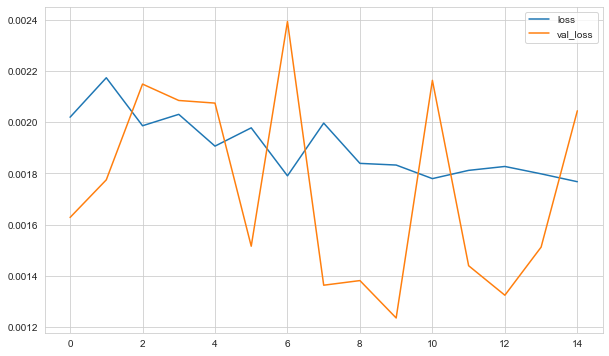

In [41]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [43]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual,pred))
    mae = mean_absolute_error(actual,pred)
    mse = mean_squared_error(actual,pred)
    score = r2_score(actual,pred)
    return print('R2 score:', score, '\nmae:', mae, '\nmse:', mse, '\nrmse:',rmse)

In [44]:
pred_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    current_pred = model.predict(current_batch)
    pred_scaled.append(current_pred[0])
    
    current_batch = np.append(current_batch[:,1:,:], [current_pred], axis=1)

In [45]:
eval_metrics(test_scaled[:length], pred_scaled)

R2 score: -1.1761957854106107 
mae: 0.15000664547521939 
mse: 0.027138551584078578 
rmse: 0.16473782681606122


#### Inverse Transformations and Comparing

In [46]:
predictions = scaler.inverse_transform(pred_scaled)

In [50]:
length

12

In [51]:
compare = test[:length]

In [53]:
compare['Predictions'] = predictions
compare

,Sales,Predictions
DATE,,
2017-10-01,90.473,90.800
2017-11-01,77.438,88.475
2017-12-01,75.812,93.511
2018-01-01,83.434,108.302
2018-02-01,99.490,121.852
2018-03-01,107.315,130.452
2018-04-01,112.431,139.262
2018-05-01,110.354,150.882
2018-06-01,124.584,148.520


<AxesSubplot:xlabel='DATE'>

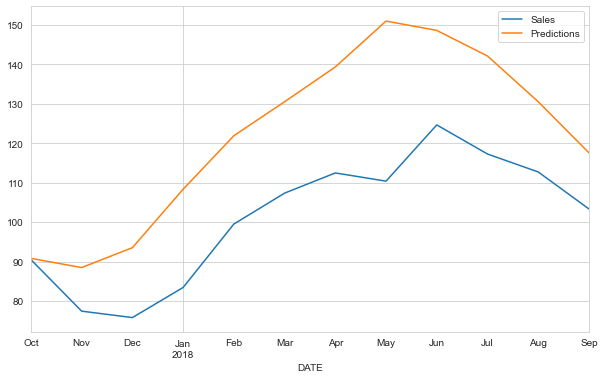

In [54]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [55]:
eval_metrics(compare.Sales, compare.Predictions)

R2 score: -1.1761957854106093 
mae: 20.627998845214766 
mse: 513.1919832433551 
rmse: 22.65374104300116


### with "relu" activation function

In [56]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(n_features))        # =1
model.compile(optimizer = 'adam', loss = 'mse')

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [58]:
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [60]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=batch_size)

In [61]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
537/537 [==============================] - 10s 9ms/step - loss: 0.0277 - val_loss: 0.0036
Epoch 2/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0095 - val_loss: 0.0035
Epoch 3/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 4/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 5/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 6/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 7/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 8/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 9/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0037 - val_loss: 0.0023


<AxesSubplot:>

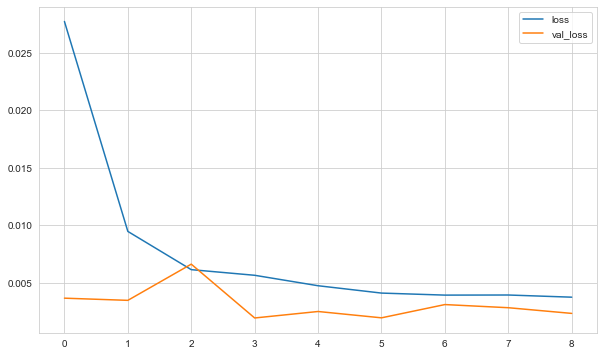

In [62]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [64]:
pred_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    current_pred = model.predict(current_batch)
    pred_scaled.append(current_pred[0])
    
    current_batch = np.append(current_batch[:,1:,:], [current_pred], axis=1)

In [65]:
eval_metrics(test_scaled[:length], pred_scaled)

R2 score: 0.7268430549115308 
mae: 0.04599659813443968 
mse: 0.0034064415961700886 
rmse: 0.058364729042205694


#### Inverse Transformations and Comparing

In [66]:
predictions = scaler.inverse_transform(pred_scaled)

In [67]:
compare['Predictions'] = predictions
compare

,Sales,Predictions
DATE,,
2017-10-01,90.473,92.346
2017-11-01,77.438,86.773
2017-12-01,75.812,89.810
2018-01-01,83.434,98.281
2018-02-01,99.490,106.905
2018-03-01,107.315,113.186
2018-04-01,112.431,118.202
2018-05-01,110.354,121.992
2018-06-01,124.584,123.511


<AxesSubplot:xlabel='DATE'>

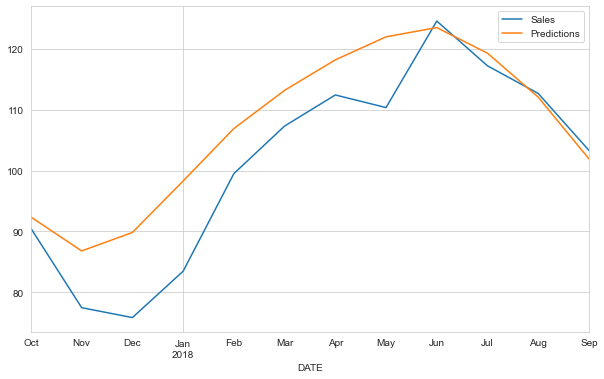

In [68]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [69]:
eval_metrics(compare.Sales, compare.Predictions)

R2 score: 0.7268430549115312 
mae: 6.32517159619952 
mse: 64.4160582087506 
rmse: 8.025961513036965


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [70]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [71]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [72]:
len(df), len(generator)

(573, 561)

In [77]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 6s 6ms/step - loss: 0.0242
Epoch 2/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0107
Epoch 3/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0064
Epoch 4/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0058
Epoch 5/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0060
Epoch 6/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0059
Epoch 7/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0049
Epoch 8/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0046
Epoch 9/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0039
Epoch 10/15
561/561 [==============================] - 4s 6ms/step - loss: 0.0036
Epoch 11/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0034
Epoch 12/15
561/561 [==============================] - 4s 6ms/step - loss: 0.0030
Epoch 13/15
561/561 [====

In [78]:
scaled_full_data.shape

(573, 1)

In [74]:
scaled_full_data[-length:].shape

(12, 1)

In [79]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [80]:
forecast = scaler.inverse_transform(forecast)

In [81]:
forecast

array([[ 90.87041599],
       [ 84.96200493],
       [ 84.34883952],
       [ 92.12211898],
       [100.83987326],
       [107.65975196],
       [112.27616619],
       [116.1072974 ],
       [117.23563946],
       [113.03265913],
       [107.46206956],
       [100.46929458]])

In [83]:
df

,Sales
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [86]:
forecast_index = pd.date_range(start = '2019-09-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [87]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-09-01,90.870
2019-10-01,84.962
2019-11-01,84.349
2019-12-01,92.122
2020-01-01,100.840
2020-02-01,107.660
2020-03-01,112.276
2020-04-01,116.107
2020-05-01,117.236
2020-06-01,113.033


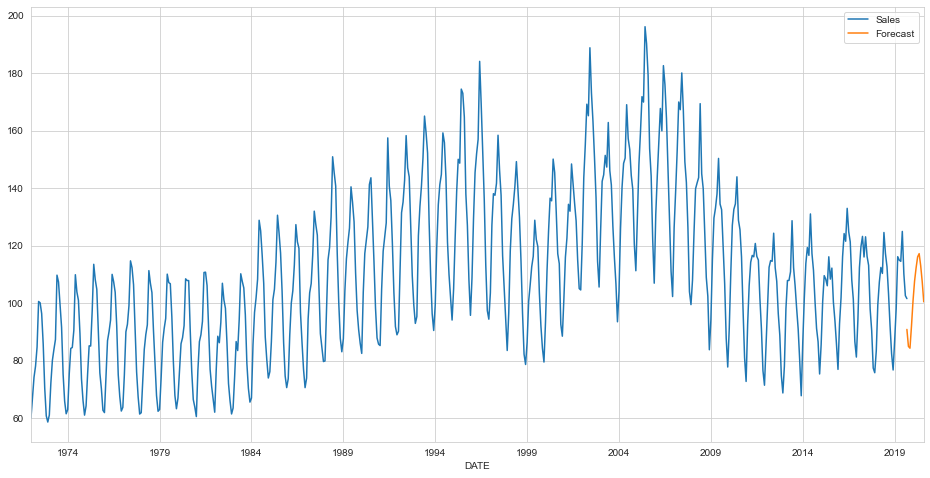

In [89]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

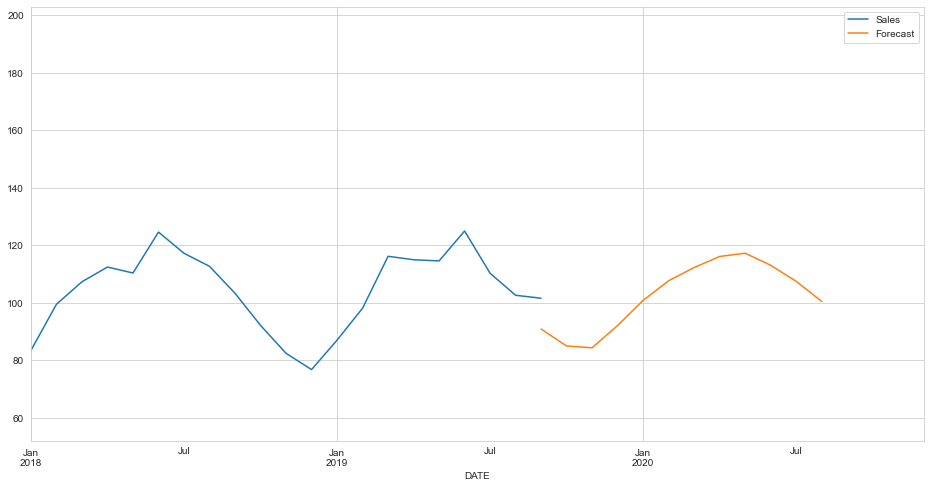

In [90]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')